In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install utils

In [ ]:
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss
import pandas as pd
from torch import optim
import re
import json
import cv2
import types
import fastai
#from fastprogress import force_console_behavior
import fastprogress
fastprogress.fastprogress.NO_BAR = True
#master_bar, progress_bar = force_console_behavior()
fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar
from PIL import Image
from utils import *
import os


In [ ]:
%cd DL
%mkdir train-224

[Errno 2] No such file or directory: 'DL'
/content


In [ ]:
j = json.load(open('/content/drive/MyDrive/FaceDetection/bbox.json'))

In [ ]:
len(j)

8356

## RESIZE IMAGE TO (224,224)


In [ ]:
SZ = 224
c = 0
for i in range(len(j)):
  try:
    a = PIL.Image.open(f"/content/drive/MyDrive/FaceDetection/part1/{j[i]['filenam']}").resize((SZ,SZ), resample=PIL.Image.BICUBIC).save(f"/content/train-224/{j[i]['filenam']}")
  except:
    c += 1
    print(f"{j[i]['filenam']}")
print(c)

0


## CREATE DATABUNCH

In [ ]:
idxs = np.arange(len(j))
np.random.seed(0)
np.random.shuffle(idxs)
val_idxs = idxs[:1671]


In [ ]:
val_j = [anno for i, anno in enumerate(j) if i in val_idxs]
#test_j = [anno for i, anno in enumerate(j) if i in test_idxs]
#trn_j = [anno for i, anno in enumerate(j) if i not in val_idxs]

In [ ]:
pd.to_pickle([anno['filenam'] for anno in val_j], '/content/drive/MyDrive/FaceDetection/part1/val_fns_detection.pkl') # this will allow me to use the same validation set across NBs
#pd.to_pickle([anno['filenam'] for anno in test_j], '/content/drive/MyDrive/FaceDetection/part1/test_fns_detection.pkl') # this will allow me to use the same validation set across NBs


In [ ]:
def anno2bbox(anno):
    im_width, im_height = PIL.Image.open(f"/content/drive/MyDrive/FaceDetection/part1/{anno['filenam']}").size
    anno = list(filter(lambda a: a['class'] == 'face', anno['annotations']))[0]
    return [
        np.clip(anno['y'], 0, im_height) / im_height * SZ,
        np.clip(anno['x'], 0, im_width) / im_width * SZ,
        np.clip(anno['y']+anno['h'], 0, im_height) / im_height * SZ,
        np.clip(anno['x']+anno['w'], 0, im_width) / im_width * SZ
    ]

In [ ]:
def get_y_func(o):
  return fn2bbox[path2fn(o)]

In [ ]:
def path2fn(path):
  return re.search('\w*\.jpg$', path).group(0)

In [ ]:
fn2bbox = {jj['filenam']: [[anno2bbox(jj)], ['face']] for jj in j}


In [ ]:
val_fns = pd.read_pickle('/content/drive/MyDrive/FaceDetection/part1/val_fns_detection.pkl') # create file val_fns
#test = pd.read_pickle('/content/drive/MyDrive/FaceDetection/part1/test_fns_detection.pkl') # create file val_fns

In [ ]:
class StubbedObjectCategoryList(ObjectCategoryList):
    def analyze_pred(self, pred): return [pred.unsqueeze(0), torch.ones(1).long()]

In [ ]:
SZ = 224
BS = 64
NUM_WORKERS = 12

In [ ]:
data = (ObjectItemList.from_df(pd.DataFrame(data=list(fn2bbox.keys())), path='/content/train-224')
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)                         
        .label_from_func(get_y_func,label_cls=StubbedObjectCategoryList)
        .transform(get_transforms(max_zoom=1, max_warp=0.05, max_rotate=0.05, max_lighting=0.2), tfm_y=True, size=(SZ,SZ), resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS)
        .normalize(imagenet_stats))

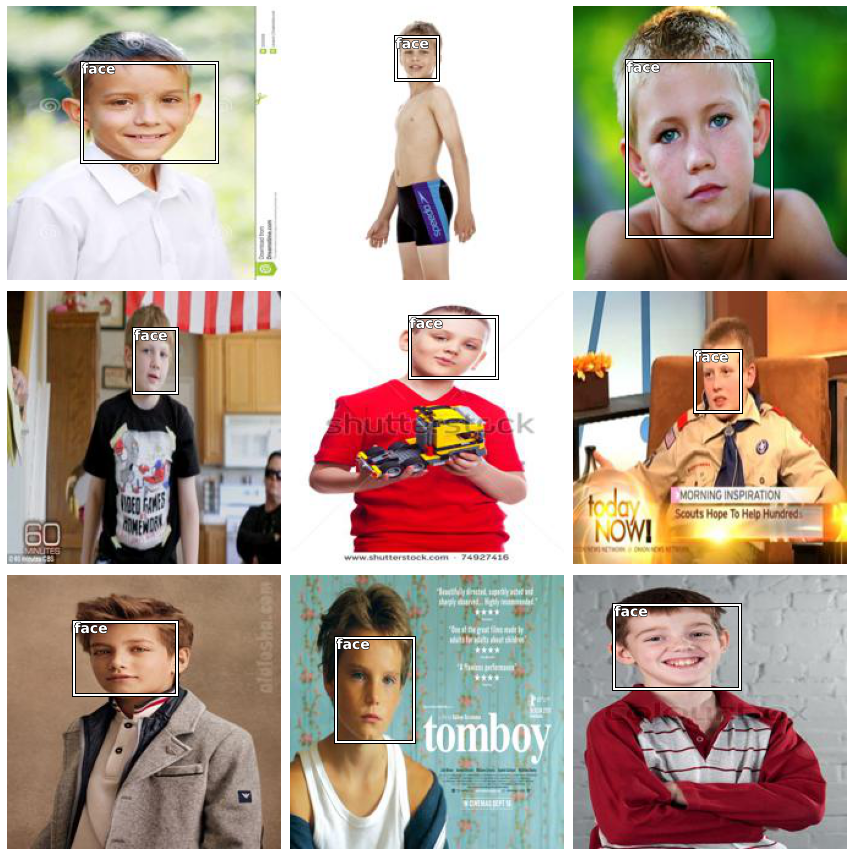

In [ ]:
data.show_batch(rows=3, ds_type=DatasetType.Valid, figsize=(12,12))

In [ ]:
data

## TRAINING MODEL

In [ ]:
class FaceDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 2 * (x.sigmoid_() - 0.5)

In [ ]:
def loss_fn(preds, targs, class_idxs):
    return L1Loss()(preds, targs.squeeze())

In [ ]:
def intersection(preds, targs):
    # preds and targs are of shape (bs, 4), pascal_voc format
    max_xy = torch.min(preds[:, 2:], targs[:, 2:])
    min_xy = torch.max(preds[:, :2], targs[:, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, 0] * inter[:, 1]

def area(boxes): 
    return ((boxes[:, 2]-boxes[:, 0]) * (boxes[:, 3]-boxes[:, 1]))

def union(preds, targs):
    return area(preds) + area(targs) - intersection(preds, targs)

def IoU(preds, targs):
    return intersection(preds, targs) / union(preds, targs)

In [ ]:
def acc_detection(preds, targs, _):
  return IoU(preds, targs.squeeze()).mean()

In [ ]:
metrics = acc_detection

In [ ]:
learn = Learner(data, FaceDetector(arch=models.resnet34),metrics=metrics, loss_func=loss_fn)


In [ ]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [ ]:
learn.freeze_to(-1)

In [ ]:
learn.fit_one_cycle(10, 1e-3, div_factor=25, pct_start=0.3)

epoch,train_loss,valid_loss,acc_detection,time
0,0.475289,0.405325,0.081608,00:54
1,0.374792,0.237363,0.275911,00:54
2,0.228059,0.147087,0.500036,00:54
3,0.165528,0.119859,0.566889,00:53
4,0.140887,0.107055,0.600580,00:54
5,0.122181,0.093066,0.640215,00:55
6,0.107024,0.076695,0.687889,00:54
7,0.094982,0.066505,0.717560,00:55
8,0.089185,0.062861,0.735358,00:55
9,0.085610,0.061520,0.736506,00:54


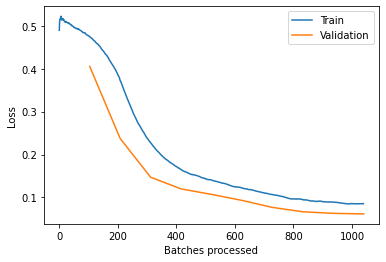

In [ ]:
learn.recorder.plot_losses()

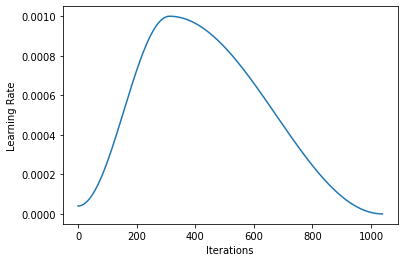

In [ ]:
learn.recorder.plot_lr()

epoch,train_loss,valid_loss,acc_detection,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


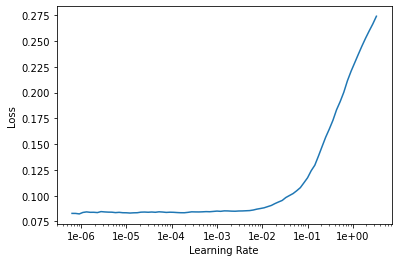

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.unfreeze()

In [ ]:
max_lr = 1e-3
lrs = np.array([max_lr/100, max_lr/10, max_lr])

In [ ]:
learn.fit_one_cycle(15, lrs)

epoch,train_loss,valid_loss,acc_detection,time
0,0.081362,0.054733,0.764043,00:57
1,0.075843,0.049842,0.777569,00:57
2,0.070378,0.052530,0.770813,00:57
3,0.069428,0.058062,0.762607,00:56
4,0.067184,0.048784,0.789963,00:56
5,0.065613,0.056817,0.781511,00:57
6,0.062185,0.054470,0.777502,00:58
7,0.059679,0.040272,0.828607,00:57
8,0.059223,0.046224,0.814116,00:58
9,0.056779,0.041027,0.831329,00:58


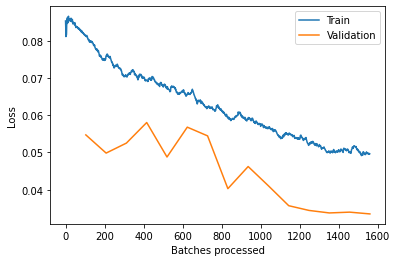

In [ ]:
learn.recorder.plot_losses()

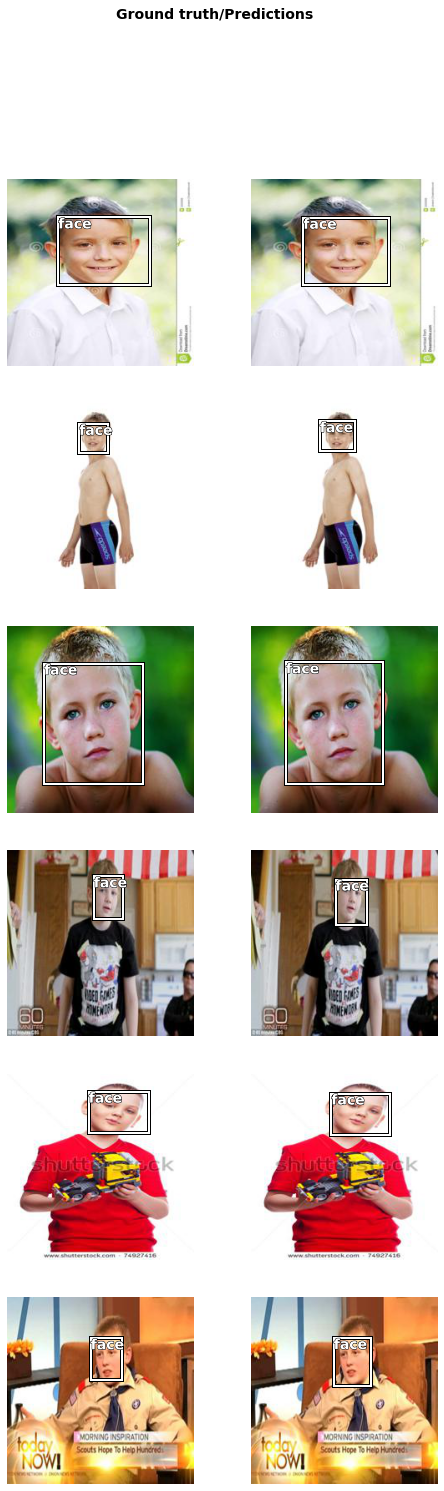

In [ ]:
learn.show_results(rows=6)


In [ ]:
learn.export('facedetect.pkl')

In [ ]:
!cp /content/drive/MyDrive/FaceDetection/train-224/facedetect.pkl '/content/facedetec.pkl'

In [ ]:
from IPython.display import FileLink
FileLink('facedetection.pkl')

In [ ]:
# Return bbdoxs to orginal
#predicted_bboxes = ((preds + 1) / 2 * SZ).numpy()
#targets = ((targs + 1) / 2 * SZ).numpy().squeeze() comapre with ground truth

In [ ]:
def draw_bbox(img, bbox, target=None, color=(255, 0, 0), thickness=2):
     y_min, x_min, y_max, x_max = map(int, bbox)
     cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
     #if target is not None:
     #    y_min, x_min, y_max, x_max = map(int, target)
     #    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=thickness)
     return img

In [ ]:
def cv_read(path):    
  im = cv2.imread(path, cv2.IMREAD_COLOR)
  return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

## Predict one image


In [ ]:
learn = load_learner(path)

NameError: ignored

In [ ]:
img = open_image('/content/mtrong.jpg')
img

NameError: ignored

In [ ]:
size_image,pred_idx,preds= learn.predict(img)

In [ ]:
predicted_bboxes = ((preds + 1) / 2 * SZ).numpy()

In [ ]:
!cp /content/mtrong.jpg '/content/train-224/test/mtrong.jpg'

In [ ]:
a = PIL.Image.open('/content/drive/MyDrive/FaceDetection/mtrong.jpg').resize((224,224), resample=PIL.Image.BICUBIC).save('/content/mtrong.jpg')

In [ ]:
ims = np.stack([draw_bbox(cv_read('/content/mtrong.jpg'), predicted_bboxes)])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

In [ ]:
learn.export()

In [ ]:
!cp /content/drive/MyDrive/FaceDetection/part1/val_fns_detection.pkl '/content/drive/MyDrive/FaceDetection/val_fns_detection.pkl'


## Evaluate on test set


In [ ]:
test = ObjectItemList.from_folder(p/'test')

In [ ]:
test

ObjectItemList (11 items)
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: /content/train-224/test

In [ ]:
learn = load_learner(path,test=test,tfm_y=False)


In [ ]:
preds,targets = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
learn.export("facedetection.pkl")

In [ ]:
!cp /content/train-224/facedetection.pkl 'facedetection.pkl'


In [ ]:
from IPython.display import FileLink
FileLink('facedetection.pkl')

/content/facedetection.pkl

## EVALUEATE ON VALID

In [ ]:
preds, targs = learn.get_preds()

In [ ]:
predicted_bboxes = ((preds + 1) / 2 * SZ).numpy()
targets = ((targs + 1) / 2 * SZ).numpy().squeeze()

In [ ]:
def draw_bbox(img, bbox, target=None, color=(255, 0, 0), thickness=2):
     y_min, x_min, y_max, x_max = map(int, bbox)
     cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
     if target is not None:
         y_min, x_min, y_max, x_max = map(int, target)
         cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=thickness)
     return img

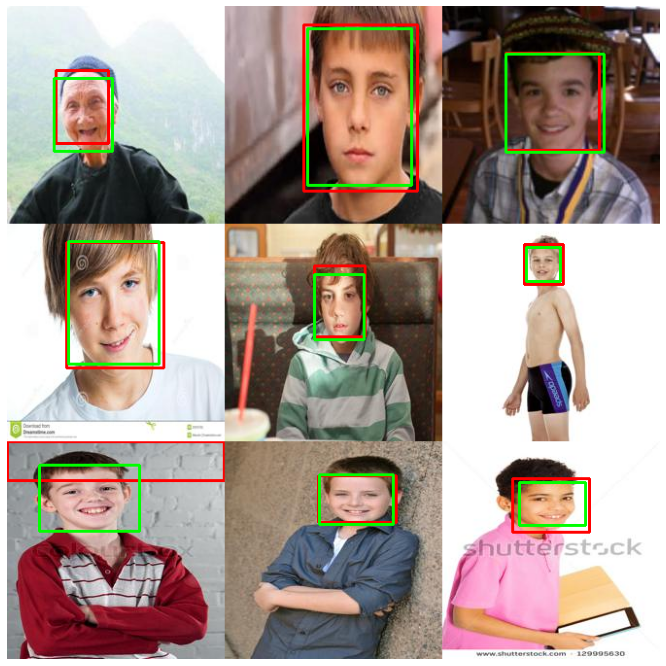

In [ ]:
ims = np.stack([draw_bbox(cv_read(data.valid_ds.items[i]), predicted_bboxes[i], targets[i]) for i in range(9)])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))